In [714]:
#Data Augmentation
import pandas as pd
import numpy as np
import random


file_path = r"C:\Users\Rayan\Desktop\fraud_insurance_claims.csv"
df = pd.read_csv(file_path)


numeric_columns = ['age', 'policy_deductable', 'policy_annual_premium',
                   'capital-gains', 'capital-loss', 'total_claim_amount',
                   'injury_claim', 'property_claim', 'vehicle_claim']
categorical_columns = ['policy_state', 'insured_sex']


fraud_ratio = 0.2
total_samples = 1000000
num_fraud_samples = int(total_samples * fraud_ratio)
num_non_fraud_samples = total_samples - num_fraud_samples


fraud_data = df[df['fraud_reported'] == 'Y']
non_fraud_data = df[df['fraud_reported'] == 'N']


fraud_bootstrap = fraud_data.sample(n=num_fraud_samples, replace=True, random_state=42)
non_fraud_bootstrap = non_fraud_data.sample(n=num_non_fraud_samples, replace=True, random_state=42)


bootstrapped_data = pd.concat([fraud_bootstrap, non_fraud_bootstrap]).sample(frac=1, random_state=42)


for col in numeric_columns:
    if col in bootstrapped_data.columns:
        col_std = bootstrapped_data[col].std()
        # Scale noise based on std deviation
        noise_scale = 0.05 * col_std if col_std > 0 else 0.01
        noise = np.random.normal(0, noise_scale, size=bootstrapped_data.shape[0])
        bootstrapped_data[col] += noise


for col in categorical_columns:
    if col in bootstrapped_data.columns:
        unique_vals = bootstrapped_data[col].unique()
        bootstrapped_data[col] = bootstrapped_data[col].apply(
            lambda x: random.choice(unique_vals) if np.random.rand() < 0.05 else x
        )


output_path = r"C:\Users\Rayan\Desktop\Data_100k.csv"
bootstrapped_data.to_csv(output_path, index=False)


In [715]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import joblib

In [716]:
data = pd.read_csv(r"C:\Users\Rayan\Desktop\Data_100k.csv")

In [717]:
data.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,222,38.745043,698470,2008-06-17 00:00:00,IN,100/300,1985.464460,1141.271428,0,433853,...,2,YES,61027.567940,6853.245400,6522.080467,46916.275714,Accura,TL,2001,N
1,217,38.564156,394975,2002-06-02 00:00:00,IN,100/300,1008.582861,1537.989692,0,603993,...,1,YES,4879.734326,360.027659,501.912871,3259.629023,Toyota,Corolla,2000,N
2,257,40.242527,414913,2012-07-17 00:00:00,IN,250/500,534.403485,1377.188638,0,608228,...,2,YES,49920.564990,9651.778151,4499.504685,39511.616258,Audi,A3,2002,Y
3,266,41.491167,281388,1998-07-16 00:00:00,IL,500/1000,953.271923,763.425543,0,473389,...,3,YES,68846.787991,8181.942612,7675.263102,56640.013074,Jeep,Grand Cherokee,2005,N
4,164,31.551670,357808,2011-01-31 00:00:00,IN,500/1000,476.609983,1128.439861,0,474758,...,0,NO,4705.454649,411.795896,197.118916,2511.875637,Mercedes,E400,2002,N


In [718]:
# Handle missing values or invalid placeholders
data.replace('?', np.nan, inplace=True)

In [719]:
# Drop columns with too many missing values (if any)
data.dropna(axis=1, thresh=len(data) * 0.9, inplace=True)

In [720]:
# Fill missing values with the mean for numeric columns and mode for categorical columns
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col] = data[col].fillna(data[col].mean())
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].fillna(data[col].mode()[0])

In [721]:
# Convert date columns to datetime
data['policy_bind_date'] = pd.to_datetime(data['policy_bind_date'], errors='coerce')
data['incident_date'] = pd.to_datetime(data['incident_date'], errors='coerce')

In [722]:
# Feature engineering
data['policy_to_incident_days'] = (data['incident_date'] - data['policy_bind_date']).dt.days
data['total_claim_ratio'] = (data['injury_claim'] + data['property_claim'] + data['vehicle_claim']) / data['total_claim_amount']

In [723]:
data.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,policy_to_incident_days,total_claim_ratio
0,222,38.745043,698470,2008-06-17,IN,100/300,1985.464460,1141.271428,0,433853,...,61027.567940,6853.245400,6522.080467,46916.275714,Accura,TL,2001,N,2441,0.987940
1,217,38.564156,394975,2002-06-02,IN,100/300,1008.582861,1537.989692,0,603993,...,4879.734326,360.027659,501.912871,3259.629023,Toyota,Corolla,2000,N,4648,0.844630
2,257,40.242527,414913,2012-07-17,IN,250/500,534.403485,1377.188638,0,608228,...,49920.564990,9651.778151,4499.504685,39511.616258,Audi,A3,2002,Y,929,1.074966
3,266,41.491167,281388,1998-07-16,IL,500/1000,953.271923,763.425543,0,473389,...,68846.787991,8181.942612,7675.263102,56640.013074,Jeep,Grand Cherokee,2005,N,6047,1.053023
4,164,31.551670,357808,2011-01-31,IN,500/1000,476.609983,1128.439861,0,474758,...,4705.454649,411.795896,197.118916,2511.875637,Mercedes,E400,2002,N,1456,0.663228


In [724]:
# Encoding categorical variables
categorical_columns = ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level',
                       'insured_occupation', 'insured_hobbies', 'insured_relationship',
                       'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted',
                       'incident_state', 'incident_city', 'auto_make', 'auto_model']

In [725]:
# Keep only columns that exist in the dataset
categorical_columns = [col for col in categorical_columns if col in data.columns]

In [726]:
# Apply one-hot encoding
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [727]:
data.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,...,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6
0,222,38.745043,698470,2008-06-17,1985.464460,1141.271428,0,433853,-1373.989084,-63848.876787,...,False,False,False,False,True,False,False,False,False,False
1,217,38.564156,394975,2002-06-02,1008.582861,1537.989692,0,603993,-959.042125,1066.152726,...,False,False,False,False,False,False,False,False,False,False
2,257,40.242527,414913,2012-07-17,534.403485,1377.188638,0,608228,481.329699,-990.032295,...,False,False,False,False,False,False,False,False,False,False
3,266,41.491167,281388,1998-07-16,953.271923,763.425543,0,473389,13823.858918,-48086.658441,...,False,False,False,False,False,False,False,False,False,False
4,164,31.551670,357808,2011-01-31,476.609983,1128.439861,0,474758,44203.686545,-55884.031256,...,False,False,False,False,False,False,False,False,False,False


In [728]:
data.shape[0]

100000

In [729]:
# Label encoding for fraud
if 'fraud_reported' in data.columns:
    data['fraud_reported'] = data['fraud_reported'].apply(lambda x: 1 if x == 'Y' else 0)

In [730]:
# Drop unnecessary columns and split dataset
X = data.drop(['fraud_reported', 'policy_bind_date', 'incident_date', 'incident_location', 'umbrella_limit'], axis=1, errors='ignore')
y = data['fraud_reported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [731]:
y.value_counts()

fraud_reported
0    80000
1    20000
Name: count, dtype: int64

In [732]:
data.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,...,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6
0,222,38.745043,698470,2008-06-17,1985.464460,1141.271428,0,433853,-1373.989084,-63848.876787,...,False,False,False,False,True,False,False,False,False,False
1,217,38.564156,394975,2002-06-02,1008.582861,1537.989692,0,603993,-959.042125,1066.152726,...,False,False,False,False,False,False,False,False,False,False
2,257,40.242527,414913,2012-07-17,534.403485,1377.188638,0,608228,481.329699,-990.032295,...,False,False,False,False,False,False,False,False,False,False
3,266,41.491167,281388,1998-07-16,953.271923,763.425543,0,473389,13823.858918,-48086.658441,...,False,False,False,False,False,False,False,False,False,False
4,164,31.551670,357808,2011-01-31,476.609983,1128.439861,0,474758,44203.686545,-55884.031256,...,False,False,False,False,False,False,False,False,False,False


In [733]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import joblib
import numpy as np
import matplotlib.pyplot as plt

In [734]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import joblib

# Random Forest


In [735]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import joblib
import numpy as np
import matplotlib.pyplot as plt

In [736]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

In [737]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nROC AUC Score:", rf_auc)

Confusion Matrix:
 [[24089     0]
 [    0  5911]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24089
           1       1.00      1.00      1.00      5911

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000


ROC AUC Score: 1.0


In [738]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
print("\nTop 10 Important Features:")
for i in range(min(10, len(indices))):
    print(f"Feature {indices[i]}: Importance {importances[indices[i]]:.4f}")


Top 10 Important Features:
Feature 70: Importance 0.0638
Feature 71: Importance 0.0582
Feature 47: Importance 0.0565
Feature 5: Importance 0.0392
Feature 2: Importance 0.0384
Feature 17: Importance 0.0333
Feature 0: Importance 0.0322
Feature 48: Importance 0.0317
Feature 4: Importance 0.0295
Feature 1: Importance 0.0278


In [739]:
joblib.dump(rf_model, "rf_model.pkl")
print("Random Forest model saved as rf_model.pkl")

Random Forest model saved as rf_model.pkl


In [740]:
sample_rf = X_test.iloc[:1]
loaded_rf = joblib.load("rf_model.pkl")
pred_rf = loaded_rf.predict(sample_rf)
print(f"Random Forest Sample Prediction: {'Fraud' if pred_rf[0] == 1 else 'Not Fraud'}")

Random Forest Sample Prediction: Not Fraud


# Logistic Regression

In [741]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [742]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [743]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
log_accuracy = accuracy_score(y_test, y_pred_log)
log_auc = roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1])


In [744]:
y_pred_log = log_model.predict(X_test_scaled)

In [745]:
print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1]))

Logistic Regression Results
Accuracy: 0.9053
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94     24089
           1       0.80      0.69      0.74      5911

    accuracy                           0.91     30000
   macro avg       0.86      0.83      0.84     30000
weighted avg       0.90      0.91      0.90     30000

ROC AUC Score: 0.9352619012171488


In [746]:
joblib.dump(log_model, "logistic_model.pkl")
print("Logistic Regression model saved as logistic_model.pkl")

Logistic Regression model saved as logistic_model.pkl


In [747]:
sample_log = X_test_scaled[:1]
loaded_log = joblib.load("logistic_model.pkl")
pred_log = loaded_log.predict(sample_log)
print(f"Logistic Regression Sample Prediction: {'Fraud' if pred_log[0] == 1 else 'Not Fraud'}")

Logistic Regression Sample Prediction: Fraud


# XGBoost

In [748]:
from xgboost import XGBClassifier

In [749]:
xgb = XGBClassifier(eval_metric="logloss", scale_pos_weight=3)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

In [750]:
y_pred_xgb = xgb.predict(X_test)

In [751]:
print("--- XGBoost Results ---")
print(f"Accuracy: {xgb_accuracy}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_xgb)}")
print("ROC AUC Score:", xgb_auc)

--- XGBoost Results ---
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24089
           1       1.00      1.00      1.00      5911

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

ROC AUC Score: 1.0


In [752]:
joblib.dump(xgb, "xgb_model.pkl")
print("XGBoost model saved as xgb_model.pkl")

XGBoost model saved as xgb_model.pkl


In [753]:
sample_xgb = X_test.iloc[:1]
loaded_xgb = joblib.load("xgb_model.pkl")
pred_xgb = loaded_xgb.predict(sample_xgb)
print(f"XGBoost Sample Prediction: {'Fraud' if pred_xgb[0] == 1 else 'Not Fraud'}")


XGBoost Sample Prediction: Not Fraud


# Naive Bayes

In [754]:
from sklearn.naive_bayes import GaussianNB

In [755]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_auc = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])

In [756]:
y_pred_nb = nb.predict(X_test)

In [757]:
print("Results: Naive Bayes")
print("Accuracy: ", nb_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("ROC AUC Score:", nb_auc)

Results: Naive Bayes
Accuracy:  0.7289666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.84     24089
           1       0.24      0.18      0.21      5911

    accuracy                           0.73     30000
   macro avg       0.53      0.52      0.52     30000
weighted avg       0.70      0.73      0.71     30000

ROC AUC Score: 0.6013094634212544


In [758]:
joblib.dump(nb, "naive_bayes_model.pkl")
print("Naive Bayes model saved as naive_bayes_model.pkl")

Naive Bayes model saved as naive_bayes_model.pkl


In [759]:
sample_nb = X_test.iloc[:1]
loaded_nb = joblib.load("naive_bayes_model.pkl")
pred_nb = loaded_nb.predict(sample_nb)
print(f"Naive Bayes Sample Prediction: {'Fraud' if pred_nb[0] == 1 else 'Not Fraud'}")


Naive Bayes Sample Prediction: Not Fraud


# KNN Classifier

In [760]:
from sklearn.neighbors import KNeighborsClassifier


In [761]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])

In [762]:
y_pred_knn = knn.predict(X_test_scaled)

In [763]:
print("KNN Classification")
print(f"Accuracy Score: {knn_accuracy}")
print("Classification Report:\n{classification_report(y_test, y_pred_knn)}")
print("ROC AUC Score:", knn_auc)

KNN Classification
Accuracy Score: 1.0
Classification Report:
{classification_report(y_test, y_pred_knn)}
ROC AUC Score: 1.0


In [764]:
joblib.dump(knn, "knn_model.pkl")
print("K-Nearest Neighbors model saved as knn_model.pkl")

K-Nearest Neighbors model saved as knn_model.pkl


In [765]:
sample_knn = X_test_scaled[:1]
loaded_knn = joblib.load("knn_model.pkl")
pred_knn = loaded_knn.predict(sample_knn)
print(f"KNN Sample Prediction: {'Fraud' if pred_knn[0] == 1 else 'Not Fraud'}")

KNN Sample Prediction: Not Fraud


# Visualization

In [766]:
models = ['Random Forest', 'Logistic Regression', 'XGBoost', 'Naive Bayes', 'KNN']
accuracies = [rf_accuracy, log_accuracy, xgb_accuracy, nb_accuracy, knn_accuracy]
aucs = [rf_auc, log_auc, xgb_auc, nb_auc, knn_auc]

In [767]:
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

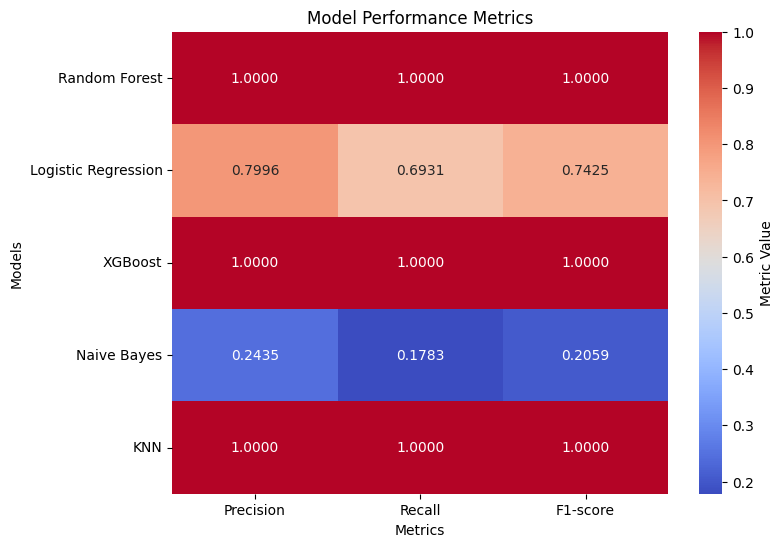

In [768]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Creating emty list to store the differnet metrics
precisions = []
recalls = []
f1_scores = []

# Evaluate each model on Precision, Recall, and F1-score
# Random Forest
y_pred_rf = rf_model.predict(X_test)
precisions.append(precision_score(y_test, y_pred_rf))
recalls.append(recall_score(y_test, y_pred_rf))
f1_scores.append(f1_score(y_test, y_pred_rf))

# Logistic Regression
y_pred_log = log_model.predict(X_test_scaled)
precisions.append(precision_score(y_test, y_pred_log))
recalls.append(recall_score(y_test, y_pred_log))
f1_scores.append(f1_score(y_test, y_pred_log))

# XGBoost
y_pred_xgb = xgb.predict(X_test)
precisions.append(precision_score(y_test, y_pred_xgb))
recalls.append(recall_score(y_test, y_pred_xgb))
f1_scores.append(f1_score(y_test, y_pred_xgb))

# Naive Bayes
y_pred_nb = nb.predict(X_test)
precisions.append(precision_score(y_test, y_pred_nb))
recalls.append(recall_score(y_test, y_pred_nb))
f1_scores.append(f1_score(y_test, y_pred_nb))

# KNN
y_pred_knn = knn.predict(X_test_scaled)
precisions.append(precision_score(y_test, y_pred_knn))
recalls.append(recall_score(y_test, y_pred_knn))
f1_scores.append(f1_score(y_test, y_pred_knn))

# Create a matrix of metrics
metrics = np.array([precisions, recalls, f1_scores]).T
metric_labels = ['Precision', 'Recall', 'F1-score']

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(metrics, annot=True, fmt=".4f", cmap="coolwarm", xticklabels=metric_labels, yticklabels=models, cbar_kws={'label': 'Metric Value'})
plt.title("Model Performance Metrics")
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.show()


In [769]:
best_model_index = np.argmax(aucs)
best_model = models[best_model_index]
print(f"The best model for fraud detection is: {best_model} with an AUC of {aucs[best_model_index]:.4f}")


The best model for fraud detection is: Random Forest with an AUC of 1.0000
